In [1]:
from Utils.Solver import *
from Utils.Signals import *

In [2]:
# Let's assume we are interested in the following stocks: AAPL, MSFT, TSLA, AMZN, GOOG
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOG']
# Signal scores for AAPL, MSFT, TSLA, AMZN, GOOG
signal_scores = np.array([1.0, 1.5, 0.5, 0.25, 1.75])  # Example signal scores
start_date ='2021-01-15'
end_date ='2022-01-15'

# Step 1: Download historical stock data
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


## Signals 

In [3]:
import yfinance as yf
import talib as ta
import pandas as pd
import numpy as np

# Fetch stock data
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOG']
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')

[*********************100%***********************]  5 of 5 completed


### RSI SIGNAL

In [4]:
# Calculate the RSI signal scores
rsi_signal_scores = calculate_rsi_signal(data, tickers, date='2022-12-23', period=14)
rsi_scores = [score[1] for score in rsi_signal_scores]
rsi_scores_array = np.array(rsi_scores)
print(rsi_scores_array)

[35.69463804 44.14049931 19.81992342 38.02756082 40.44854483]


     pcost       dcost       gap    pres   dres
 0: -1.2478e-01 -1.1479e+00  1e+00  0e+00  3e+00
 1: -1.2557e-01 -1.5230e-01  3e-02  1e-16  7e-02
 2: -1.2688e-01 -1.2801e-01  1e-03  6e-17  1e-03
 3: -1.2692e-01 -1.2694e-01  2e-05  2e-16  1e-05
 4: -1.2692e-01 -1.2692e-01  2e-07  1e-16  1e-07
 5: -1.2692e-01 -1.2692e-01  2e-09  1e-16  1e-09
Optimal solution found.
Optimized Portfolio Weights:
{'AAPL': np.float64(0.20048001147846273), 'MSFT': np.float64(0.2597471613782587), 'TSLA': np.float64(0.08908238876516543), 'AMZN': np.float64(0.2168508325418608), 'GOOG': np.float64(0.2338396058362524)}
Final Portfolio Weights: [0.20048001 0.25974716 0.08908239 0.21685083 0.23383961]


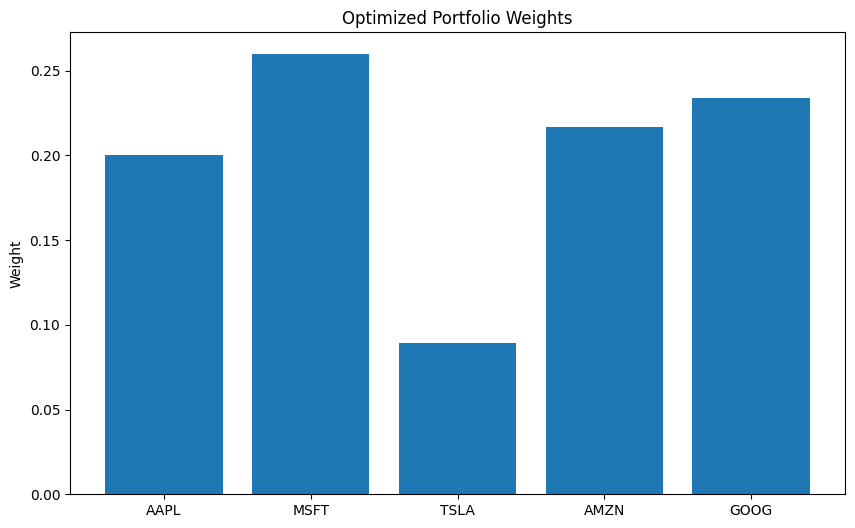

In [5]:
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)
rsi_portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, rsi_scores_array)
print("Final Portfolio Weights:", rsi_portfolio_weights)
portfolio_solver.ShowPortfolioWeights(tickers=tickers, portfolio_weights=rsi_portfolio_weights)

Total Portfolio Return: 147.66%
Annualized Portfolio Return: 147.66%


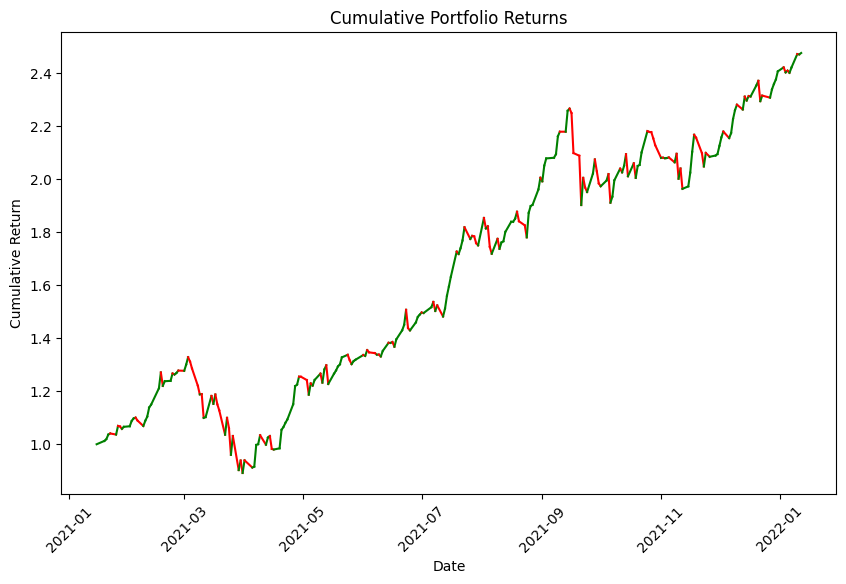

In [6]:
# Calculate portfolio returns and performance
cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, rsi_portfolio_weights)
# Show the portfolio performance plot
portfolio_solver.ShowPortfolioPerformance(cumulative_returns, data, start_date, end_date)

### MACD signal

In [7]:
# Calculate MACD for a specific date (e.g., '2021-01-15')
macd_signal = calculate_macd_signal(data, tickers, '2021-01-15')
macd_scores = [score[1] for score in macd_signal]
macd_scores_array = np.array(macd_scores)

     pcost       dcost       gap    pres   dres
 0: -5.1576e+00 -3.2420e+00  2e+01  5e+00  1e+00
 1: -9.9484e-01 -1.9725e+00  1e+00  9e-03  2e-03
 2: -1.0944e+00 -1.1813e+00  9e-02  7e-04  2e-04
 3: -1.1233e+00 -1.1306e+00  7e-03  2e-05  4e-06
 4: -1.1260e+00 -1.1268e+00  8e-04  2e-16  1e-16
 5: -1.1262e+00 -1.1262e+00  7e-05  1e-16  4e-17
 6: -1.1262e+00 -1.1262e+00  9e-07  2e-16  3e-16
Optimal solution found.
Optimized Portfolio Weights:
{'AAPL': np.float64(0.3348127141777124), 'MSFT': np.float64(0.6384794770954505), 'TSLA': np.float64(3.0397808323766853e-09), 'AMZN': np.float64(0.026707790390430676), 'GOOG': np.float64(1.5296625553123973e-08)}
Final Portfolio Weights: [3.34812714e-01 6.38479477e-01 3.03978083e-09 2.67077904e-02
 1.52966256e-08]


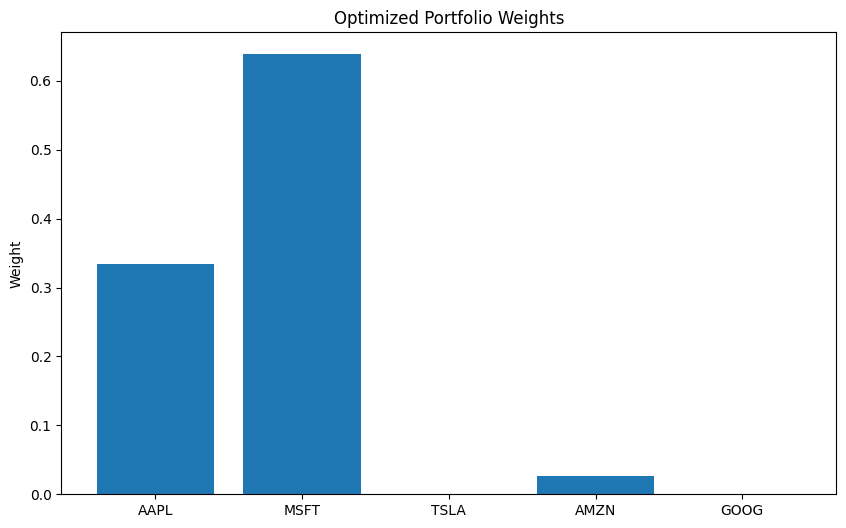

In [8]:
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)
macd_portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, macd_scores_array)
print("Final Portfolio Weights:", macd_portfolio_weights)
portfolio_solver.ShowPortfolioWeights(tickers=tickers, portfolio_weights=macd_portfolio_weights)

Total Portfolio Return: 76.57%
Annualized Portfolio Return: 76.57%


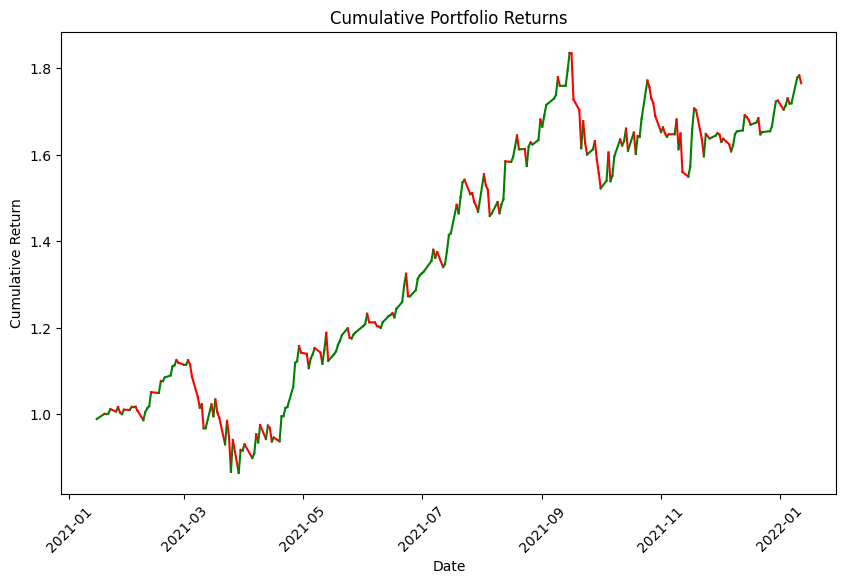

In [9]:
# Calculate portfolio returns and performance
cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, macd_portfolio_weights)
# Show the portfolio performance plot
portfolio_solver.ShowPortfolioPerformance(cumulative_returns, data, start_date, end_date)

### SMA signal

In [10]:
# Calculate SMA crossover signal for a specific date (e.g., '2021-01-15')
sma_signal = calculate_sma_signal(data, tickers, '2021-01-15')
sma_scores = [score[1] for score in sma_signal]
sma_scores_array = np.array(sma_scores)
print(sma_scores_array)

[19.99331093 13.46059334 81.52420954 11.69167049 11.39482943]


     pcost       dcost       gap    pres   dres
 0: -2.0345e-01 -1.3608e+00  1e+00  0e+00  3e+00
 1: -2.2219e-01 -3.2681e-01  1e-01  1e-16  3e-01
 2: -2.3998e-01 -2.5115e-01  1e-02  2e-16  1e-16
 3: -2.4069e-01 -2.4133e-01  6e-04  2e-16  5e-17
 4: -2.4070e-01 -2.4071e-01  8e-06  3e-16  8e-17
 5: -2.4070e-01 -2.4070e-01  8e-08  1e-16  2e-17
Optimal solution found.
Optimized Portfolio Weights:
{'AAPL': np.float64(0.13101375485007336), 'MSFT': np.float64(0.0718684888513506), 'TSLA': np.float64(0.688098001676304), 'AMZN': np.float64(0.055853551218007176), 'GOOG': np.float64(0.05316620340426492)}
Final Portfolio Weights: [0.13101375 0.07186849 0.688098   0.05585355 0.0531662 ]


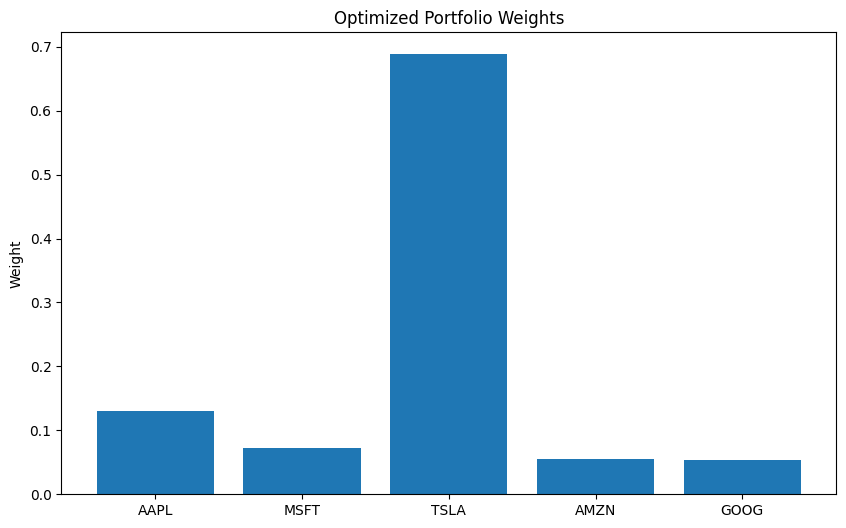

In [11]:
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)
sma_portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, sma_scores_array)
print("Final Portfolio Weights:", sma_portfolio_weights)
portfolio_solver.ShowPortfolioWeights(tickers=tickers, portfolio_weights=sma_portfolio_weights)

Total Portfolio Return: 54.65%
Annualized Portfolio Return: 54.65%


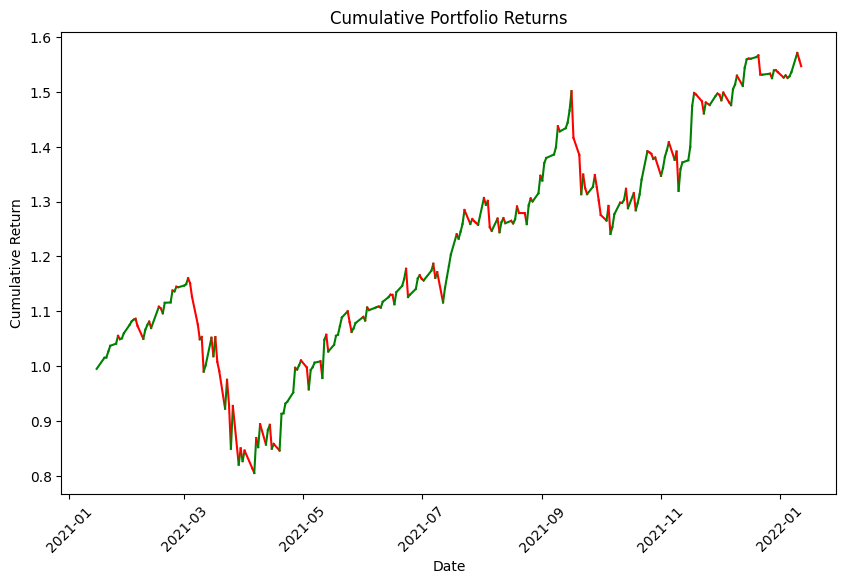

In [12]:
# Calculate portfolio returns and performance
cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, sma_portfolio_weights)
# Show the portfolio performance plot
portfolio_solver.ShowPortfolioPerformance(cumulative_returns, data, start_date, end_date)

rsi_signal_scores [48.09325589 42.67415394 66.28230185 42.67309414 46.45340692]
macd_signal_scores [-0.81744828 -0.98491465  1.88721933 -0.64751188 -0.12669542]
sma_signal_scores [19.99331093 13.46059334 81.52420954 11.69167049 11.39482943]
[ 67.26911854  55.14983263 149.69373072  53.71725276  57.72154093]
     pcost       dcost       gap    pres   dres
 0: -1.3988e-01 -1.2314e+00  1e+00  0e+00  3e+00
 1: -1.4431e-01 -2.1518e-01  7e-02  2e-16  2e-01
 2: -1.4874e-01 -1.5166e-01  3e-03  9e-17  5e-17
 3: -1.4876e-01 -1.4879e-01  3e-05  2e-16  3e-17
 4: -1.4876e-01 -1.4876e-01  3e-07  2e-16  1e-17
 5: -1.4876e-01 -1.4876e-01  3e-09  8e-17  1e-17
Optimal solution found.
Optimized Portfolio Weights:
{'AAPL': np.float64(0.16923106057436296), 'MSFT': np.float64(0.12973413290140207), 'TSLA': np.float64(0.43785410462603824), 'AMZN': np.float64(0.12506533536350825), 'GOOG': np.float64(0.1381153665346886)}


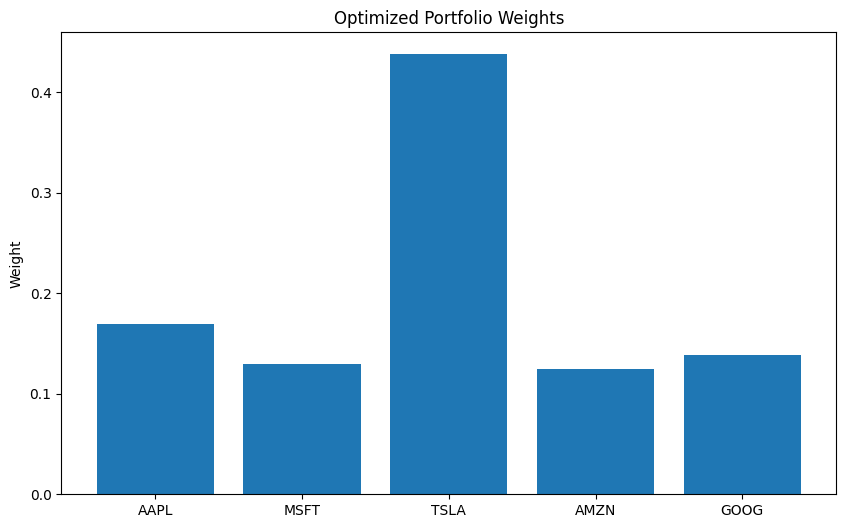

Total Portfolio Return: 92.24%
Annualized Portfolio Return: 92.24%


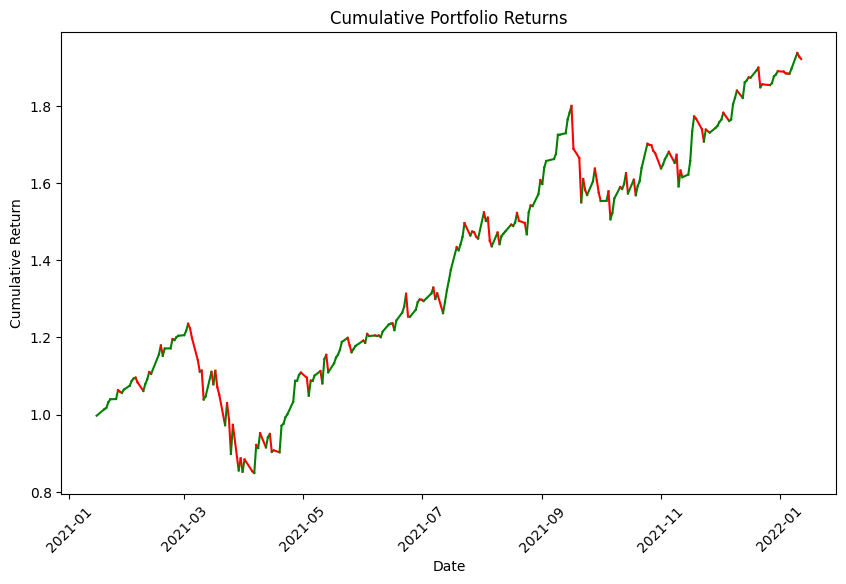

In [13]:

trading_dates = ['2021-01-15']
# Example of Iterative Optimization
for date in trading_dates:
    # Step 1: Calculate the signals for this specific date
    rsi_signal_scores = calculate_rsi_signal(data, tickers, date, period=14)
    rsi_scores_array = np.array([score[1] for score in rsi_signal_scores])
    print("rsi_signal_scores", rsi_scores_array)

    macd_signal_scores = calculate_macd_signal(data, tickers, date)
    macd_scores_array = np.array([score[1] for score in macd_signal_scores])
    print("macd_signal_scores", macd_scores_array)

    sma_signal_scores = calculate_sma_signal(data, tickers, date)
    sma_scores_array = np.array([score[1] for score in sma_signal_scores])
    print("sma_signal_scores", sma_scores_array)


    # Step 2: Combine the signals into a single combined score
    signal_weights = [1,1,1]
    signal_scores = [rsi_scores_array, macd_scores_array, sma_scores_array]
    combined_scores = combine_signals(signal_weights, signal_scores)
    print(combined_scores)
    
    # Step 3: Optimize portfolio based on the combined signal scores
    portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, combined_scores)
    portfolio_solver.ShowPortfolioWeights(tickers=tickers, portfolio_weights=portfolio_weights)
    
    # Step 4: Update the portfolio weights for this date
    cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, portfolio_weights)
    #cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, sma_portfolio_weights)
    # Optionally, store the results or plot the performance over time
    portfolio_solver.ShowPortfolioPerformance(cumulative_returns, data, start_date=date, end_date='2022-01-15')
    


# Prepare data

In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
from Utils.Solver import *
from Utils.Signals import *

# Download historical stock data
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOG']
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')

# Initialize the portfolio solver with appropriate penalty and max weight threshold
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)

# Define the target date range
start_date = '2021-01-01'
end_date = '2022-01-01'
date_range = pd.date_range(start=start_date, end=end_date)

# Initialize an empty list to store the rows of the dataset
dataset = []

# Iterate over each date in the target range to calculate the signals and portfolio returns
for date in date_range:
    print(f"processing {date}")

    # Step 1: Calculate the RSI signal scores
    rsi_signal_scores = calculate_rsi_signal(data, tickers, date=date, period=14)
    rsi_scores = np.array([score[1] for score in rsi_signal_scores])

    # Step 2: Calculate the MACD signal scores
    macd_signal_scores = calculate_macd_signal(data, tickers, date=date)
    macd_scores = np.array([score[1] for score in macd_signal_scores])

    # Step 3: Calculate the SMA signal scores
    sma_signal_scores = calculate_sma_signal(data, tickers, date=date)
    sma_scores = np.array([score[1] for score in sma_signal_scores])

    if np.any(np.isnan(rsi_scores)) or np.any(np.isnan(macd_scores)) or np.any(np.isnan(sma_scores)):
        print(f"Skipping {date} due to NaN values in the signals.")
        continue  # Skip this date and move to the next one

    print(f"RSI : {rsi_signal_scores}")
    print(f"MACD : {macd_signal_scores}")
    print(f"SMA : {sma_scores}")

    # Step 4: Combine the signals (this step can be adjusted later based on how you combine them)
    signal_weights = [1, 1, 1]  # You can later train a model to adjust these weights
    combined_scores = combine_signals(signal_weights, [rsi_scores, macd_scores, sma_scores])
    combined_scores_with_tickers = list(zip(tickers, combined_scores))

    print(f"Combined Scores", combined_scores_with_tickers)
    
    # Step 5: Solve the portfolio based on the combined signal scores
    portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, combined_scores)

    # Step 6: Calculate the returns for the portfolio based on the optimized weights
    cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, portfolio_weights, start_date=date, time_period=30)  # time_period=1 for daily returns
    
    # Add the calculated values to the dataset
    dataset.append({
        'date': date,
        'rsi_scores': rsi_scores,
        'macd_scores': macd_scores,
        'sma_scores': sma_scores,
        'combined_scores': combined_scores,
        'portfolio_weights': portfolio_weights,
        'total_return': total_return,
        'annualized_return': annualized_return
    })


# Convert the dataset into a DataFrame
df = pd.DataFrame(dataset)

# Display the dataset (this will include the RSI, MACD, SMA scores, portfolio weights, and returns)

# You can now use this DataFrame for training your model.
display(df)

[*********************100%***********************]  5 of 5 completed


processing 2021-01-01 00:00:00
Skipping 2021-01-01 00:00:00 due to NaN values in the signals.
processing 2021-01-02 00:00:00
Skipping 2021-01-02 00:00:00 due to NaN values in the signals.
processing 2021-01-03 00:00:00
Skipping 2021-01-03 00:00:00 due to NaN values in the signals.
processing 2021-01-04 00:00:00
RSI : [['AAPL', np.float64(54.95767800954394)], ['MSFT', np.float64(48.90810225722883)], ['TSLA', np.float64(71.86002956306031)], ['AMZN', np.float64(48.36221551762188)], ['GOOG', np.float64(45.15980646103864)]]
MACD : [['AAPL', np.float64(0.03976346499928596)], ['MSFT', np.float64(-0.03355781476224262)], ['TSLA', np.float64(0.42445878093217004)], ['AMZN', np.float64(0.19824201898529015)], ['GOOG', np.float64(-0.2823898691775783)]]
SMA : [20.08162233 14.96210434 67.97656604 14.46491592 11.45227551]
Combined Scores [('AAPL', np.float64(75.07906380806983)), ('MSFT', np.float64(63.836648782066185)), ('TSLA', np.float64(140.2610543821242)), ('AMZN', np.float64(63.02537346067944)), (

,date,rsi_scores,macd_scores,sma_scores,combined_scores,portfolio_weights,total_return,annualized_return
0,2021-01-04,"[54.95767800954394, 48.90810225722883, 71.8600...","[0.03976346499928596, -0.03355781476224262, 0....","[20.08162233352661, 14.962104339599591, 67.976...","[75.07906380806983, 63.836648782066185, 140.26...","[0.18548640506007105, 0.15022443513970804, 0.3...",0.128082,1.752076
1,2021-01-05,"[57.72293973121864, 49.294367630843716, 72.475...","[-0.1463159526608564, -0.3087972462397339, 0.8...","[20.021948528289798, 14.637324066162108, 68.95...","[77.59857230684759, 63.62289445076609, 142.247...","[0.187368309128851, 0.1446177450453751, 0.3851...",0.119915,1.589128
2,2021-01-06,"[48.8253665857461, 40.4352473236895, 74.793754...","[-0.5603159931445818, -0.8311067770523204, 1.3...","[19.905597991943367, 14.19844329833984, 70.076...","[68.17064858454489, 53.80258384497702, 146.201...","[0.17201361477362218, 0.12522066881697183, 0.4...",0.133032,1.855185
3,2021-01-07,"[55.98302948293307, 50.64659602340684, 80.0120...","[-0.5499999024999718, -0.7593184236131214, 2.7...","[19.87966085433959, 14.024462890624989, 71.523...","[75.31269043477269, 63.91174049041871, 154.263...","[0.1730301872013374, 0.13926754113987505, 0.40...",0.080958,0.923068
4,2021-01-08,"[57.651543809646185, 52.5746141819678, 83.8481...","[-0.4718696806698479, -0.6071581484973063, 4.6...","[19.83840225219727, 13.801931381225586, 73.271...","[77.01807638117361, 65.76938741469608, 161.800...","[0.16961651630096675, 0.1375409608772324, 0.41...",0.026499,0.245698
...,...,...,...,...,...,...,...,...
247,2021-12-27,"[66.90668781116545, 59.34075054749564, 58.3541...","[-0.12650258961209193, 0.2901701767120253, 2.5...","[16.69149631500244, 43.19119194030759, 89.7060...","[83.4716815365558, 102.82211266451526, 150.581...","[0.17885909962321525, 0.2319132881128865, 0.36...",-0.076719,-0.488548
248,2021-12-28,"[64.96682622416509, 58.199756228297005, 57.658...","[-0.061326127668431596, 0.7186016893326275, 3....","[17.09822322845457, 43.39803482055663, 90.7081...","[82.00372332495122, 102.31639273818627, 152.28...","[0.1760738634497744, 0.23207331662495773, 0.36...",-0.060340,-0.407135
249,2021-12-29,"[65.0612661502665, 58.69867882342527, 57.35103...","[-0.05801148997096117, 0.9835989300505941, 4.5...","[17.48044204711914, 43.56929954528806, 91.4664...","[82.48369670741468, 103.25157729876392, 153.39...","[0.17746739789001323, 0.23473951422169234, 0.3...",-0.048308,-0.340266
250,2021-12-30,"[62.6765137384813, 55.99460297662967, 55.15212...","[-0.1731693578135456, 0.9232898221985839, 4.44...","[17.797927398681622, 43.68069236755372, 92.226...","[80.30127177934938, 100.59858516638198, 151.82...","[0.1759517163829427, 0.2330642976468031, 0.377...",-0.062946,-0.420805


Calculate all the return for each of those dates



In [15]:
average_annualized_return = df['annualized_return'].mean()
print("Average return for 1/N : ", average_annualized_return)

Average return for 1/N :  0.5146743593099199


### Matrix of size signals 

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from Utils.Solver import *
from Utils.Signals import *

# Download historical stock data
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOG']
data = yf.download(tickers, start='2015-01-01', end='2023-01-01')

# Initialize the portfolio solver with appropriate penalty and max weight threshold
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)

# Define the target date range
start_date = '2019-01-01'
end_date = '2022-01-01'
date_range = pd.date_range(start=start_date, end=end_date)

# Initialize an empty list to store the rows of the dataset
dataset = []

# Iterate over each date in the target range to calculate the signals and portfolio returns
for date in date_range:
    #print(f"processing {date}")

    # Step 1: Calculate the RSI signal scores
    rsi_signal_scores = calculate_rsi_signal(data, tickers, date=date, period=14)
    rsi_scores = np.array([score[1] for score in rsi_signal_scores])

    # Step 2: Calculate the MACD signal scores
    macd_signal_scores = calculate_macd_signal(data, tickers, date=date)
    macd_scores = np.array([score[1] for score in macd_signal_scores])

    # Step 3: Calculate the SMA signal scores
    sma_signal_scores = calculate_sma_signal(data, tickers, date=date)
    sma_scores = np.array([score[1] for score in sma_signal_scores])

    if np.any(np.isnan(rsi_scores)) or np.any(np.isnan(macd_scores)) or np.any(np.isnan(sma_scores)):
        #print(f"Skipping {date} due to NaN values in the signals.")
        continue  # Skip this date and move to the next one

    # Calculate the average scores for each signal type (RSI, MACD, SMA)
    avg_rsi = np.mean(rsi_scores)
    avg_macd = np.mean(macd_scores)
    avg_sma = np.mean(sma_scores)

    # Add the aggregated values to the dataset
    dataset.append({
        'date': date,
        'rsi_avg': avg_rsi,
        'macd_avg': avg_macd,
        'sma_avg': avg_sma,
        'rsi_scores': rsi_scores,
        'macd_scores': macd_scores,
        'sma_scores': sma_scores,
        'total_return': total_return 
    })

# Convert the dataset into a DataFrame
df = pd.DataFrame(dataset)

# Prepare the feature matrix X (aggregated values for RSI, MACD, SMA)
X = df[['rsi_avg', 'macd_avg', 'sma_avg']].values

# Prepare the target y (total return)
y = df['total_return'].values.reshape(-1, 1)

# Initialize and train a linear model to learn the weight matrix W (size should be 3)
W, _, _, _ = np.linalg.lstsq(X, y, rcond=None)

# Output the learned weight matrix W
print("Learned Weight Matrix (W):")
print(W)


[*********************100%***********************]  5 of 5 completed


Learned Weight Matrix (W):
[[-0.00131903]
 [ 0.00582608]
 [-0.00042525]]


In [17]:
# Define the target date range
start_date = '2021-01-01'
end_date = '2022-01-01'
date_range = pd.date_range(start=start_date, end=end_date)

# Initialize an empty list to store the rows of the dataset
dataset = []

# Iterate over each date in the target range to calculate the signals and portfolio returns
for date in date_range:
    print(f"processing {date}")

    # Step 1: Calculate the RSI signal scores
    rsi_signal_scores = calculate_rsi_signal(data, tickers, date=date, period=14)
    rsi_scores = np.array([score[1] for score in rsi_signal_scores])

    # Step 2: Calculate the MACD signal scores
    macd_signal_scores = calculate_macd_signal(data, tickers, date=date)
    macd_scores = np.array([score[1] for score in macd_signal_scores])

    # Step 3: Calculate the SMA signal scores
    sma_signal_scores = calculate_sma_signal(data, tickers, date=date)
    sma_scores = np.array([score[1] for score in sma_signal_scores])

    if np.any(np.isnan(rsi_scores)) or np.any(np.isnan(macd_scores)) or np.any(np.isnan(sma_scores)):
        print(f"Skipping {date} due to NaN values in the signals.")
        continue  # Skip this date and move to the next one

    print(f"RSI : {rsi_signal_scores}")
    print(f"MACD : {macd_signal_scores}")
    print(f"SMA : {sma_scores}")

    # Step 4: Combine the signals (this step can be adjusted later based on how you combine them)
    signal_weights = W  # You can later train a model to adjust these weights
    combined_scores = combine_signals(signal_weights, [rsi_scores, macd_scores, sma_scores])
    combined_scores_with_tickers = list(zip(tickers, combined_scores))

    print(f"Combined Scores", combined_scores_with_tickers)
    
    # Step 5: Solve the portfolio based on the combined signal scores
    portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, combined_scores)

    # Step 6: Calculate the returns for the portfolio based on the optimized weights
    cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, portfolio_weights, start_date=date, time_period=30)  # time_period=1 for daily returns
    
    # Add the calculated values to the dataset
    dataset.append({
        'date': date,
        'rsi_scores': rsi_scores,
        'macd_scores': macd_scores,
        'sma_scores': sma_scores,
        'combined_scores': combined_scores,
        'portfolio_weights': portfolio_weights,
        'total_return': total_return,
        'annualized_return': annualized_return
    })


# Convert the dataset into a DataFrame
df = pd.DataFrame(dataset)

# Display the dataset (this will include the RSI, MACD, SMA scores, portfolio weights, and returns)

# You can now use this DataFrame for training your model.
display(df)

processing 2021-01-01 00:00:00
Skipping 2021-01-01 00:00:00 due to NaN values in the signals.
processing 2021-01-02 00:00:00
Skipping 2021-01-02 00:00:00 due to NaN values in the signals.
processing 2021-01-03 00:00:00
Skipping 2021-01-03 00:00:00 due to NaN values in the signals.
processing 2021-01-04 00:00:00
RSI : [['AAPL', np.float64(54.95767800954394)], ['MSFT', np.float64(48.90810225722883)], ['TSLA', np.float64(71.86002956306031)], ['AMZN', np.float64(48.36221551762188)], ['GOOG', np.float64(45.15980646103864)]]
MACD : [['AAPL', np.float64(0.03976346499928596)], ['MSFT', np.float64(-0.03355781476224262)], ['TSLA', np.float64(0.42445878093217004)], ['AMZN', np.float64(0.19824201898529015)], ['GOOG', np.float64(-0.2823898691775783)]]
SMA : [20.08162233 14.96210434 67.97656604 14.46491592 11.45227551]
Combined Scores [('AAPL', np.float64(-0.08079881740045805)), ('MSFT', np.float64(-0.0710693539990727)), ('TSLA', np.float64(-0.1212195387465575)), ('AMZN', np.float64(-0.0687874004986

,date,rsi_scores,macd_scores,sma_scores,combined_scores,portfolio_weights,total_return,annualized_return
0,2021-01-04,"[54.95767800954394, 48.90810225722883, 71.8600...","[0.03976346499928596, -0.03355781476224262, 0....","[20.08162233352661, 14.962104339599591, 67.976...","[-0.08079881740045805, -0.0710693539990727, -0...","[0.19757117450973083, 0.167759666673221, 0.321...",0.117607,1.544653
1,2021-01-05,"[57.72293973121864, 49.294367630843716, 72.475...","[-0.1463159526608564, -0.3087972462397339, 0.8...","[20.021948528289798, 14.637324066162108, 68.95...","[-0.0855050155712678, -0.07304430314611302, -0...","[0.2031141144111575, 0.166227599042179, 0.3057...",0.107497,1.357636
2,2021-01-06,"[48.8253665857461, 40.4352473236895, 74.793754...","[-0.5603159931445818, -0.8311067770523204, 1.3...","[19.905597991943367, 14.19844329833984, 70.076...","[-0.07613137442830592, -0.06421524621112146, -...","[0.1910251039124287, 0.15329971297672673, 0.33...",0.119027,1.571931
3,2021-01-07,"[55.98302948293307, 50.64659602340684, 80.0120...","[-0.5499999024999718, -0.7593184236131214, 2.7...","[19.87966085433959, 14.024462890624989, 71.523...","[-0.0855014093957279, -0.07719208473414292, -0...","[0.19649872880275981, 0.17254312491717763, 0.2...",0.063917,0.682776
4,2021-01-08,"[57.651543809646185, 52.5746141819678, 83.8481...","[-0.4718696806698479, -0.6071581484973063, 4.6...","[19.83840225219727, 13.801931381225586, 73.271...","[-0.08722949072619582, -0.07875406819357277, -...","[0.19939115527141435, 0.17515972458753426, 0.2...",0.001909,0.016153
...,...,...,...,...,...,...,...,...
247,2021-12-27,"[66.90668781116545, 59.34075054749564, 58.3541...","[-0.12650258961209193, 0.2901701767120253, 2.5...","[16.69149631500244, 43.19119194030759, 89.7060...","[-0.09608694181704404, -0.09494865683570325, -...","[0.22732474412713746, 0.2240394422057251, 0.23...",-0.082449,-0.514608
248,2021-12-28,"[64.96682622416509, 58.199756228297005, 57.658...","[-0.061326127668431596, 0.7186016893326275, 3....","[17.09822322845457, 43.39803482055663, 90.7081...","[-0.09332144472357609, -0.09103553630776115, -...","[0.23150615089628274, 0.22461065888752463, 0.2...",-0.066041,-0.436684
249,2021-12-29,"[65.0612661502665, 58.69867882342527, 57.35103...","[-0.05801148997096117, 0.9835989300505941, 4.5...","[17.48044204711914, 43.56929954528806, 91.4664...","[-0.09358924068499426, -0.09022256545341219, -...","[0.23759374270899608, 0.22724816474455944, 0.2...",-0.054759,-0.376902
250,2021-12-30,"[62.6765137384813, 55.99460297662967, 55.15212...","[-0.1731693578135456, 0.9232898221985839, 4.44...","[17.797927398681622, 43.68069236755372, 92.226...","[-0.09124961150753418, -0.08705454546504396, -...","[0.23749436018309675, 0.22427723133547145, 0.2...",-0.069708,-0.454994


In [21]:
average_annualized_return = df['annualized_return'].mean()
print("Average return for trained matrix : ", average_annualized_return)

Average return for trained matrix :  0.4853100392845132


### Matrix of size tickers x signals 

In [18]:
# Create the feature matrix dynamically
X = np.array([[
    row['rsi_scores'][i],  # Get RSI score for the i-th ticker
    row['macd_scores'][i],  # Get MACD score for the i-th ticker
    row['sma_scores'][i]    # Get SMA score for the i-th ticker
] for _, row in df.iterrows() for i in range(len(tickers))]).reshape(len(df), len(tickers) * 3)

# Ensure the shape of X is correct (it should be 2D with each row representing a data point)
#print("Shape of X:", X.shape)
#print(X)

# Target (returns), you can choose 'total_return' or 'annualized_return' based on your preference
y = df['total_return'].values.reshape(-1, 1)

# Initialize and train a linear model to learn the weight matrix W
# Using np.linalg.lstsq to solve the least squares problem, i.e., Y = XW
W2, _, _, _ = np.linalg.lstsq(X, y, rcond=None)

# Output the learned weight matrix W
print("Learned Weight Matrix (W):", W2)


Learned Weight Matrix (W): [[-0.00278501]
 [ 0.00069316]
 [-0.00477765]
 [-0.00260276]
 [ 0.03137855]
 [-0.00213476]
 [ 0.00211221]
 [-0.00650935]
 [ 0.00099016]
 [ 0.00085834]
 [-0.00641385]
 [ 0.00540339]
 [-0.00176332]
 [-0.04878054]
 [ 0.01800742]]


TODO: Apply W to all and calculate the return on every date

# RENDU ICI 

In [19]:
# Let's test the model with some input signals (for example, RSI=0.4, MACD=0.5, SMA=1.8)
test_data = np.array([[0.4, 0.5, 1.8]])

# Ensure test_data has the same shape as the learned weight matrix
print("Shape of test_data:", test_data.shape)

weighted_values = test_data[0] * W.flatten()
print("Weighted values : ", weighted_values)
# Predicted return (make sure the shapes are aligned)

#TODO: Solve Portfolio
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)
portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, weighted_values)
print("Final Portfolio Weights:", portfolio_weights)
portfolio_solver.ShowPortfolioWeights(tickers=tickers, portfolio_weights=rsi_portfolio_weights)

#TODO: Display



print("Predicted Return for input [RSI=0.4, MACD=0.5, SMA=1.8]:", )

Shape of test_data: (1, 3)
Weighted values :  [-0.00052761  0.00291304 -0.00076545]


TypeError: 'P' must be a 'd' matrix of size (3, 3)

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from Utils.Solver import *
from Utils.Signals import *


# Download historical stock data
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOG']
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')

# Initialize the portfolio solver with appropriate penalty and max weight threshold
portfolio_solver = Portfolio_Solver(0.8, max_weight_threshold=0.3)

# Define the target date range
start_date = '2022-01-01'
end_date = '2022-05-05'
date_range = pd.date_range(start=start_date, end=end_date)

# Initialize an empty list to store the rows of the dataset
res_dataset = []

# Iterate over each date in the target range to calculate the signals and portfolio returns
for date in date_range:
    print(f"processing {date}")

    # Step 1: Calculate the RSI signal scores
    rsi_signal_scores = calculate_rsi_signal(data, tickers, date=date, period=14)
    rsi_scores = np.array([score[1] for score in rsi_signal_scores])

    # Step 2: Calculate the MACD signal scores
    macd_signal_scores = calculate_macd_signal(data, tickers, date=date)
    macd_scores = np.array([score[1] for score in macd_signal_scores])

    # Step 3: Calculate the SMA signal scores
    sma_signal_scores = calculate_sma_signal(data, tickers, date=date)
    sma_scores = np.array([score[1] for score in sma_signal_scores])

    if np.any(np.isnan(rsi_scores)) or np.any(np.isnan(macd_scores)) or np.any(np.isnan(sma_scores)):
        print(f"Skipping {date} due to NaN values in the signals.")
        continue  # Skip this date and move to the next one

    print(f"RSI : {rsi_signal_scores}")
    print(f"MACD : {macd_signal_scores}")
    print(f"SMA : {sma_scores}")

    # Step 4: Combine the signals (this step can be adjusted later based on how you combine them)

    signal_weights = W  # You can later train a model to adjust these weights
    combined_scores = combine_signals(signal_weights, [rsi_scores, macd_scores, sma_scores])


    # Step 5: Solve the portfolio based on the combined signal scores
    portfolio_weights = portfolio_solver.SolveSignalPortfolio(tickers, data, combined_scores)

    # Step 6: Calculate the returns for the portfolio based on the optimized weights
    cumulative_returns, total_return, annualized_return = portfolio_solver.CalculatePortfolioReturns(tickers, data, portfolio_weights, start_date=date, time_period=30)  # time_period=1 for daily returns
    
    # Add the calculated values to the dataset
    res_dataset.append({
        'date': date,
        'rsi_scores': rsi_scores,
        'macd_scores': macd_scores,
        'sma_scores': sma_scores,
        'combined_scores': combined_scores,
        'portfolio_weights': portfolio_weights,
        'total_return': total_return,
        'annualized_return': annualized_return
    })


# Convert the dataset into a DataFrame
res_data = pd.DataFrame(res_dataset)

# Display the dataset (this will include the RSI, MACD, SMA scores, portfolio weights, and returns)


# You can now use this DataFrame for training your model.
display(res_data)